In [10]:
import matplotlib.pyplot as plt
import pickle as pkl
import numpy as np

% matplotlib inline

In [3]:
from torchvision import datasets, transforms
import torch

train_set = datasets.SVHN(
    root='data/',
    split='train',
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

train_loader = torch.utils.data.DataLoader(
    dataset=train_set, 
    batch_size=128, shuffle=True, num_workers=0)

Using downloaded and verified file: data/train_32x32.mat


In [5]:
images, labels = next(iter(train_loader))

images.size()

torch.Size([128, 3, 32, 32])

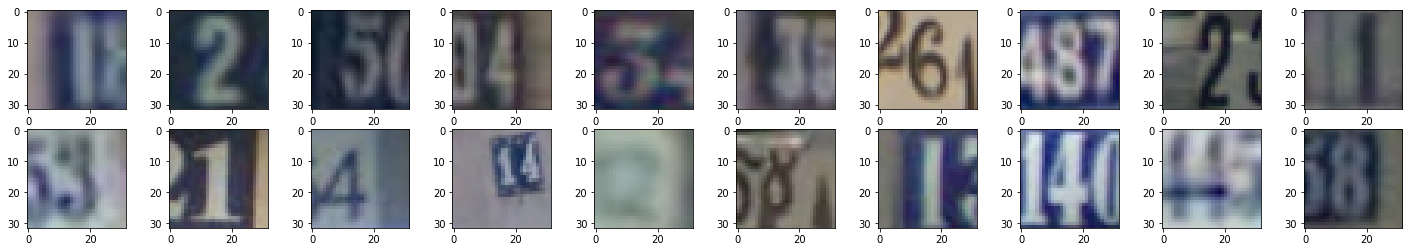

In [18]:
fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1)
    ax.imshow(images[idx].numpy().transpose((1,2,0)))

In [26]:
img = images[0]
print(img.size())
print(img.min())
print(img.max())

torch.Size([3, 32, 32])
tensor(0.1137)
tensor(0.6353)


In [23]:
def scale(x, feature_range=(-1, 1)):
    min, max = feature_range    
    return x * (max - min) + min
    
scaled_img = scale(img)    
print(scaled_img.min())
print(scaled_img.max())

tensor(-0.7725)
tensor(0.2706)


In [40]:
import torch.nn as nn
import torch.nn.functional as F


def conv(in_channels, 
         out_channels, kernal_size=4, stride=2, 
         padding=1, batch_norm=True):
    
    layers = []
    conv_layer = nn.Conv2d(
        in_channels, 
        out_channels, 
        kernal_size, 
        stride, 
        padding, 
        bias=False)
        
    layers.append(conv_layer)
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)
   
    
def deconv(in_channels, 
           out_channels, kernal_size=4, stride=2, 
           padding=1, batch_norm=True):
    
    layers = []
    transpose_conv_layer = nn.ConvTranspose2d(
        in_channels,
        out_channels,
        kernal_size,
        stride,
        padding,
        bias=False
    )
    
    layers.append(transpose_conv_layer)
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)


class Discriminator(nn.Module):
    def __init__(self, conv_dim=32):
        super().__init__()
        
        self.conv_dim = conv_dim
        
        # 32 x 32 input, 3 channel
        # out = (W - K + 2P) / S + 1
        # 16 = (32 - 4 + 2) / 2 + 1
        # 32 channel
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False)
        
        # 16 x 16 input
        # 8 = (16 - 4 + 2) / 2 + 1
        # 64 channel
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        
        # 8 x 8 input
        # 4 = (8 - 4 + 2) / 2 + 1
        # 128 channel
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        
        self.fc = nn.Linear(conv_dim*4*4*4, 1)
        
        
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        
        x = x.view(-1, self.conv_dim*4*4*4)        
        x = self.fc(x)
        return x
        
        
        
class Generator(nn.Module):
    def __init__(self, z_size, conv_dim=32):
        super().__init__()
        
        self.conv_dim = conv_dim
        
        self.fc = nn.Linear(z_size, conv_dim*4*4*4)
        
        # S = 2, padding = 1, output_padding = 0
        # (W - 1) * S - 2P + K + output_padding
        # (4 - 1) * 2 - 2 + 4 = 8
        self.t_conv1 = deconv(conv_dim*4, conv_dim*2, 4)
        
        # (8 - 1) * 2 - 2 + 4 = 16
        self.t_conv2 = deconv(conv_dim*2, conv_dim, 4)
        
        # (16 - 1) * 2 - 2 + 4 = 32
        self.t_conv3 = deconv(conv_dim, 3, 4, batch_norm=False)

        
    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, self.conv_dim*4, 4, 4)
        
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        
        x = self.t_conv3(x)
        x = F.tanh(x)
        
        return x

    
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    if smooth:
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size)
        
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss


def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss
        
D = Discriminator()        
G = Generator(100)
        
import torch.optim as optim
lr = 0.0002
beta1=0.5
beta2=0.999 # default value

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])


fixed_z = np.random.uniform(-1, 1, size=(16, 100))
fixed_z = torch.from_numpy(fixed_z).float()


losses = []
samples = []
for epoch in range(50):
    
    for batch_i, (images, _) in enumerate(train_loader):
        
        batch_size = images.size(0)
                
        images = scale(images)
        
        d_optimizer.zero_grad()
        
        d_real_out = D(images)
        d_real_loss = real_loss(d_real_out)
        
        z = np.random.uniform(-1, 1, size=(batch_size, 100))
        z = torch.from_numpy(z).float()
        
        g_fake_out = G(z)
        d_fake_out = D(g_fake_out)
        d_fake_loss = fake_loss(d_fake_out)
        
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        
        # train generator
        g_optimizer.zero_grad()
                
        z = np.random.uniform(-1, 1, size=(batch_size, 100))
        z = torch.from_numpy(z).float()
        
        g_out = G(z)
        d_out = D(g_out)
        g_loss = real_loss(d_out)
        g_loss.backward()
        g_optimizer.step()
        
        if batch_i % 300 == 0:
            # append discriminator loss and generator loss
            losses.append((d_loss.item(), g_loss.item()))
            # print discriminator and generator loss
            print('Epoch {:5d} | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, d_loss.item(), g_loss.item()))

    G.eval()    
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # back to training mode

with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)        

/Users/mondormo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch     1 | d_loss: 1.4300 | g_loss: 0.6615
Epoch     1 | d_loss: 0.6502 | g_loss: 2.7088
Epoch     2 | d_loss: 0.7031 | g_loss: 1.2230
Epoch     2 | d_loss: 0.7632 | g_loss: 1.6534
Epoch     3 | d_loss: 0.9953 | g_loss: 1.9525
Epoch     3 | d_loss: 0.9023 | g_loss: 0.8620
Epoch     4 | d_loss: 0.7397 | g_loss: 1.6360
Epoch     4 | d_loss: 0.8369 | g_loss: 1.4338
Epoch     5 | d_loss: 1.0015 | g_loss: 2.9352
Epoch     5 | d_loss: 0.5290 | g_loss: 1.6502
Epoch     6 | d_loss: 0.5502 | g_loss: 1.9197
Epoch     6 | d_loss: 0.3566 | g_loss: 1.8261
Epoch     7 | d_loss: 0.6072 | g_loss: 0.7101
Epoch     7 | d_loss: 0.4702 | g_loss: 2.3259
Epoch     8 | d_loss: 0.4693 | g_loss: 2.0992
Epoch     8 | d_loss: 0.3690 | g_loss: 2.1213
Epoch     9 | d_loss: 0.4581 | g_loss: 2.9217
Epoch     9 | d_loss: 0.3460 | g_loss: 2.1993
Epoch    10 | d_loss: 0.5931 | g_loss: 1.1585
Epoch    10 | d_loss: 0.3822 | g_loss: 2.9336
Epoch    11 | d_loss: 0.4115 | g_loss: 2.9715
Epoch    11 | d_loss: 0.3957 | g_l

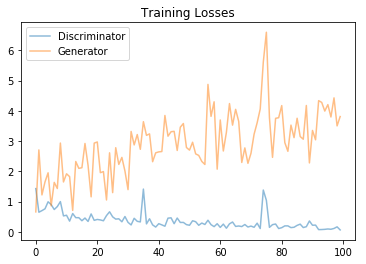

In [41]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [42]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img +1)*255 / (2)).astype(np.uint8) # rescale to pixel range (0-255)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

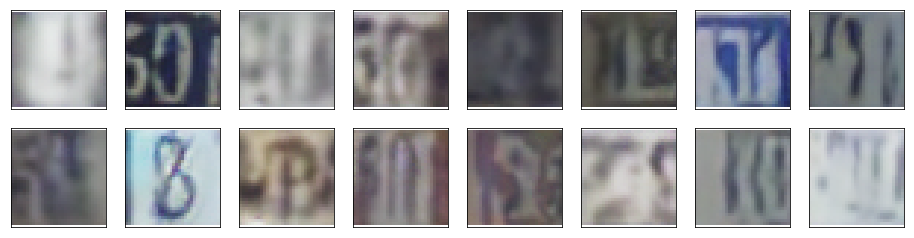

In [43]:
_ = view_samples(-1, samples)